# Setup

### Dependencies

`
pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph beautifulsoup4 langchain-google-genai langchain-huggingface langchain-chroma jupyter ipywidgets tqdm python-dotenv
`

### LangSmith

In [1]:
import os

from dotenv import load_dotenv

load_dotenv()

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_API_KEY"] = os.getenv("LANGSMITH_API_KEY")

### Components

Chat Model: Google AI

In [2]:
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY")

In [3]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-pro",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
    # other params...
)

In [4]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2",
                                   cache_folder="huggingface_models")

Vector Store: Chroma

In [5]:
from langchain_chroma import Chroma

vector_store = Chroma(embedding_function=embeddings, persist_directory="chroma_db")

# Indexing

### Loading Documents

In [6]:
# from langchain_community.document_loaders import TextLoader
# from pathlib import Path

# # Define the folder where your .txt files are stored
# txt_folder = r"D:\Mahabharat Text"

# # Load all .txt files from the folder
# file_paths = list(Path(txt_folder).glob("*.txt"))

# # Load documents
# docs = [TextLoader(str(file_path)).load()[0] for file_path in file_paths]

# # Print total character count from all files
# total_chars = sum(len(doc.page_content) for doc in docs)
# print(f"Total characters: {total_chars}")


In [7]:
from langchain_community.document_loaders import PyPDFLoader
from pathlib import Path

# Define the folder where your PDF files are stored
pdf_folder = r"./Solder_Bridging_Docs"

# Load all .pdf files from the folder
# file_paths = list(Path(pdf_folder).glob("*.pdf"))
file_paths = [Path(r"./Solder_Bridging_Docs/4.pdf")]

# Load documents
docs = []
for file_path in file_paths:
    loader = PyPDFLoader(str(file_path))
    pages = loader.load()
    docs.extend(pages)  # Append all pages of the PDF

# Print total character count from all files
total_chars = sum(len(doc.page_content) for doc in docs)
print(f"Total characters: {total_chars}")

C:\Users\Ryan\anaconda3\envs\nlp_proj_env\Lib\site-packages\pypdf\_crypt_providers\_cryptography.py:32: CryptographyDeprecationWarning: ARC4 has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.ARC4 and will be removed from cryptography.hazmat.primitives.ciphers.algorithms in 48.0.0.
  from cryptography.hazmat.primitives.ciphers.algorithms import AES, ARC4


Total characters: 17390


In [8]:
print(docs[0].page_content[:1000])

 
 
 
  
 
 
         
         
        Lead-free SMT Soldering Defects  
                 How to Prevent Them   
 
 
 
  
 
  
Author: Peter Biocca, Senior Development Engineer, Kester, Des Plaines, Illinois.  
                           Telephone 972.390.1197; email pbiocca@kester.com                                                              
                                                                                                                
                                                                                                                
 
 



### Splitting Documents

In [9]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # chunk size (characters)
    chunk_overlap=200,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split all the solder bridging docs text into {len(all_splits)} sub-documents.")

Split all the solder bridging docs text into 23 sub-documents.


### Adding metadata

In [10]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"

all_splits[0].metadata

{'source': 'Solder_Bridging_Docs\\4.pdf',
 'page': 0,
 'start_index': 41,
 'section': 'beginning'}

In [11]:
all_splits[2].metadata

{'source': 'Solder_Bridging_Docs\\4.pdf',
 'page': 1,
 'start_index': 742,
 'section': 'beginning'}

### Storing documents

In [12]:
# Batch Insert Approach
batch_size = 1000

document_ids = []
for i in range(0, len(all_splits), batch_size):
    batch = all_splits[i:max((i + batch_size), len(all_splits))]
    batch_ids = vector_store.add_documents(documents=batch)
    document_ids.extend(batch_ids)
    print(f"Inserted {i + batch_size}/{len(all_splits)} documents")

print(document_ids[:3])

Inserted 1000/23 documents
['9e5eedf8-d229-4187-aa73-f28507f04ba6', '799c2694-9799-4e27-99d0-1c7954c95fe7', '00cfe44d-9c9f-4dea-8f8f-16a591cceff3']


# Query Analysis

In [13]:
from typing import Literal
from pydantic import BaseModel, Field

class Search(BaseModel):
    """Search query."""
    query: str = Field(description="Search query to run.")
    section: Literal["beginning", "middle", "end"] = Field(description="Section to query.")

In [14]:
from langchain.prompts import PromptTemplate

custom_prompt = PromptTemplate(
    input_variables=["context", "question"],
    template="""
You are an expert AI assistant specializing in answering complex questions using retrieved context.
Your goal is to provide a detailed, structured, and well-formatted response with markdown elements.

### Question:
{question}

### Context:
{context}

### Answer:
- **Detailed Explanation:** Provide an in-depth response with supporting details using only the details given in the context.
- **Bullet Points & Formatting:** Use bullet points, subheadings, and code blocks when relevant.
- **Step-by-Step Breakdown:** If applicable, break down the answer into logical steps.
- **Examples & Analogies:** Where helpful, give real-world examples or analogies.

If the context does not contain enough information, state: "**The provided context does not have sufficient details.**"
""",
)

example_messages = custom_prompt.format(
    context="(context goes here)",
    question="(question goes here)"
)
print(example_messages)


You are an expert AI assistant specializing in answering complex questions using retrieved context.
Your goal is to provide a detailed, structured, and well-formatted response with markdown elements.

### Question:
(question goes here)

### Context:
(context goes here)

### Answer:
- **Detailed Explanation:** Provide an in-depth response with supporting details using only the details given in the context.
- **Bullet Points & Formatting:** Use bullet points, subheadings, and code blocks when relevant.
- **Step-by-Step Breakdown:** If applicable, break down the answer into logical steps.
- **Examples & Analogies:** Where helpful, give real-world examples or analogies.

If the context does not contain enough information, state: "**The provided context does not have sufficient details.**"



# Retrieval & Generation

### LangGraph

State

In [15]:
from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str

Nodes

In [16]:
def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query.query,
        filter={"section": query.section},
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = custom_prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

Control Flow

In [17]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

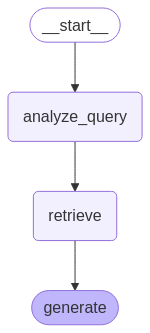

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

# Testing

In [25]:
result = graph.invoke({"question": "What are defects that can be associated with lead-free reflow soldering?"})         # Answer in Page 3   of 4.pdf

print(f'Answer: {result["answer"]}')

print(f'\n\nContext:-')
print(f"No. of docs in context: {len(result["context"])}")

for i, doc in enumerate(result["context"]):
    print(f"\nDoc {i}:")
    print(doc)

Answer: The provided context lists several differences between leaded and lead-free SMT processes, which can contribute to defects if the lead-free process is not properly implemented.  While the context doesn't explicitly list *defects*, it highlights the *differences* that can *lead* to defects if not addressed.  These differences, and therefore the potential associated defects, are:

* **Solder Physical Properties:** Differences in melting point, surface tension, oxidation potential, metallurgy, and metal leaching potential between leaded and lead-free solders can lead to various defects if not accounted for.  For example, higher surface tension can contribute to poor wetting or bridging.  Different metallurgy can lead to weakened joints or formation of intermetallic compounds that affect reliability.

* **Higher Peak Temperatures:** The higher temperatures required for lead-free soldering can cause issues such as component damage, substrate delamination, and increased oxidation.

*

In [27]:
result = graph.invoke({"question": "What are the potential failure modes during lead-free reflow soldering?"})         # Answer in Page 3   of 4.pdf

print(f'Answer: {result["answer"]}')

print(f'\n\nContext:-')
print(f"No. of docs in context: {len(result["context"])}")

for i, doc in enumerate(result["context"]):
    print(f"\nDoc {i}:")
    print(doc)

Answer: The provided context lists the following as typical defects associated with lead-free reflow soldering:

* **Bridging:**  Solder unintentionally connecting two or more adjacent component leads or solder pads.
* **Solder Balls:** Small spheres of solder that detach from the main solder deposit.
* **Mid-chip Balling:**  A specific type of solder balling that occurs under a component, often near the center of the chip.
* **Poor Wetting:** Insufficient adhesion of the solder to the component leads or solder pads, resulting in a weak connection.
* **Voids:**  Empty spaces or pockets within the solder joint, which can weaken the joint and affect its reliability.
* **Tomb-stoning:**  One end of a component lifts off the PCB during reflow, resembling a tombstone.
* **De-wetting:** The solder retracts or pulls away from the surface it is supposed to bond to, leaving exposed areas.


While the context lists these failure modes, it does *not* provide detailed explanations of *why* these f

Listing all the steps in the graph stream

In [ ]:
for step in graph.stream(
        {"question": "Why does lead-free reflow show poor wetting?"}, stream_mode="updates"             # Answer in Page 5 of 4.pdf
):
    print(f"{step}\n\n----------------\n")

{'analyze_query': {'query': Search(query='Why does lead-free reflow show poor wetting?', section='beginning')}}

----------------

{'retrieve': {'context': [Document(id='a4a87e25-2427-428e-a15a-942bec691970', metadata={'page': 1, 'section': 'beginning', 'source': 'Solder_Bridging_Docs\\4.pdf', 'start_index': 742}, page_content='Often when a manufacturer transitions to lead-free soldering an increase in defects is noticed. This is often the result of a not properly implemented process. A well-defined, \noptimized and controlled lead-free process will not augment defect rates.    The main differences between a leaded and lead-free SMT process are summarized \nbelow: \n \n\x89 Solder physical properties, melting point, surface tension, oxidation \npotential, metallurgy and metal leaching potential  \n\x89 Higher peak temperatures \n\x89 Higher preheat temperatures \n\x89 Lead-free finishes for boards and components (preferred) \n\x89 Solder cosmetics and surface effects \n\x89 Solderabili

In [ ]:
for message, metadata in graph.stream(
        {"question": "What are some causes of voids in joints?"}, stream_mode="messages"
):
    print(message.content, end="|")

|The| provided context| primarily discusses defects related to solder paste characteristics and the higher temperatures required for lead-|free soldering. While it mentions "voids" as a potential defect, it doesn|'t elaborate on their specific causes. Therefore, I will provide a more general overview of void formation in solder joints, drawing partially from the provided context and supplementing with| external knowledge.

**Causes of Voids in Solder Joints:**

Voids, essentially pockets of trapped gas, can form within solder joints during the reflow| process.  Several factors contribute to their formation:

* **Flux Activity and Outgassing:**

    * Flux, a crucial component of solder paste, cleans the surfaces to be joined and promotes wetting.  During reflow, the flux| volatilizes, and these gases need to escape before the solder solidifies.  Insufficient flux activity, rapid solidification, or the solder's surface tension can trap these gases, leading to voids.
    * The context me